In [61]:
import torch
from src.model_utils import load_model, tokenize_sentence, word2idx, load_word2vec_format, predict_single_text_DE
import torch

In [62]:
model = load_model('IMDB_DE_best_model')

w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embedding = torch.nn.Embedding.from_pretrained(embedding_weights)


In [63]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = "I love this movie. It's the best movie I've ever seen!"

print(predict_single_text_DE(text, model, device=device, model_type='IMDB', embedding=embedding))

1


In [64]:
def integrated_gradients(input_text: str,
                         model: torch.nn.Module,
                         embedding: torch.nn.Embedding,
                         num_steps: int = 50,
                         device: str = 'cpu') -> torch.Tensor:
    """
    Calculate integrated gradients for a given input text.

    Args:
        input_text (str): The input text for which to calculate the integrated gradients.
        model (torch.nn.Module): The model used for prediction.
        embedding (torch.nn.Embedding): The embedding layer to be applied to the input texts.
        num_steps (int): Number of steps for numerical integration.
        device (str): The device to run the model on.

    Returns:
        torch.Tensor: Integrated gradients for each token in the input text.
    """

    # Tokenize input 
    tokenized_input = tokenize_sentence(input_text)

    # Convert tokens to indices
    input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)
    

    # Calculate difference between input and baseline embeddings
    input_embedding = embedding(input_indices)
    baseline_embedding = torch.zeros_like(input_embedding)
    diff = input_embedding - baseline_embedding

    # Generate interpolated inputs along the path from baseline to input
    interpolated_inputs = [baseline_embedding + (float(i) / num_steps) * diff for i in range(num_steps + 1)]
    interpolated_inputs = torch.cat(interpolated_inputs, dim=0)

    # Calculate gradients of outputs with respect to interpolated inputs
    interpolated_inputs.requires_grad_(True)
    model.to(device)
    model.eval()
    outputs = model(interpolated_inputs, torch.tensor([input_embedding.shape[1]]).to(device))

    # Calculate gradients for the single output tensor
    gradients = torch.autograd.grad(outputs=outputs, inputs=interpolated_inputs)[0]

    # Calculate integrated gradients
    integrated_gradients = torch.mean(gradients, dim=0)

    return integrated_gradients

In [65]:

# Example input text
input_text = "This movie is horrible! I hated it. It's the worst movie ever."


# Calculate integrated gradients
ig = integrated_gradients(input_text, model, embedding, num_steps=100, device=device)

# Convert input text to tokens
tokenized_input = tokenize_sentence(input_text)

# Calculate absolute integrated gradients for each token
abs_ig = torch.abs(ig)

# Sort tokens based on their absolute integrated gradients (from highest to lowest)
sorted_indices = torch.argsort(abs_ig, descending=True)

# Print tokens along with their absolute integrated gradients
for i in range(len(tokenized_input)):
    token = tokenized_input[i]
    token_ig = abs_ig[i]
    print(f"Token: {token} - Absolute Integrated Gradient: {token_ig}")



Token: This - Absolute Integrated Gradient: tensor([5.1331e-05, 2.2135e-05, 8.7111e-05, 2.7715e-05, 1.3580e-04, 1.2581e-04,
        2.4987e-05, 3.2294e-05, 1.5204e-05, 6.0808e-05, 9.2678e-05, 3.3324e-05,
        2.2834e-04, 1.2228e-04, 4.2924e-05, 8.3076e-06, 1.1438e-04, 1.4351e-04,
        7.0369e-05, 1.1278e-04, 2.9535e-05, 4.5446e-05, 6.4426e-05, 7.1207e-05,
        9.4382e-05, 1.8379e-04, 1.1713e-04, 4.0878e-05, 1.6578e-04, 3.4859e-05,
        1.1129e-05, 6.4873e-06, 7.6572e-05, 3.0326e-04, 3.2592e-05, 8.9110e-05,
        5.6780e-05, 2.6217e-04, 3.5560e-05, 1.0139e-04, 3.9758e-05, 6.3758e-05,
        1.9877e-04, 2.7299e-04, 2.2495e-05, 2.0176e-04, 1.1936e-05, 7.5664e-05,
        1.8622e-04, 7.0815e-05, 1.9221e-04, 1.1066e-04, 5.4448e-05, 7.1265e-05,
        1.3081e-04, 6.8061e-05, 3.2749e-05, 5.4435e-05, 7.7288e-05, 8.6200e-05,
        1.2595e-04, 1.1354e-04, 1.2116e-04, 5.8961e-05, 1.2070e-04, 2.3563e-04,
        3.4886e-05, 3.1637e-05, 6.5990e-05, 7.0873e-05, 9.5917e-06, 1.0176e-

C:\Users\cptad\AppData\Local\Temp\ipykernel_45900\649216495.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)


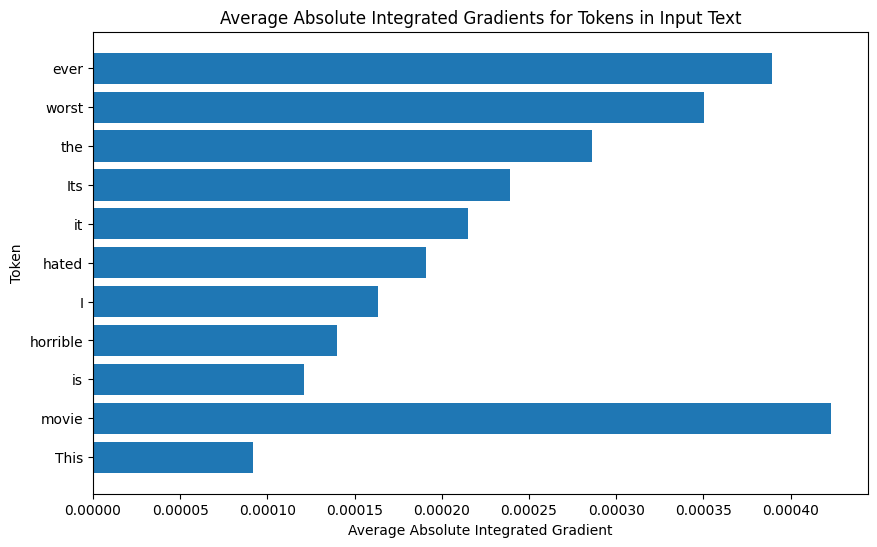

In [66]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
token_labels = tokenized_input
ig_values = abs_ig.mean(dim=1).cpu().detach().numpy()


# Plot absolute integrated gradients
plt.figure(figsize=(10, 6))
plt.barh(token_labels, ig_values)
plt.xlabel('Average Absolute Integrated Gradient')
plt.ylabel('Token')
plt.title('Average Absolute Integrated Gradients for Tokens in Input Text')
plt.show()
